In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import pandas as pd
from networkx.drawing.nx_agraph import graphviz_layout
from tabulate import tabulate
import pickle
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
from scipy.stats import wasserstein_distance
from scipy.stats import entropy
from scipy.stats import norm
warnings.filterwarnings('ignore')

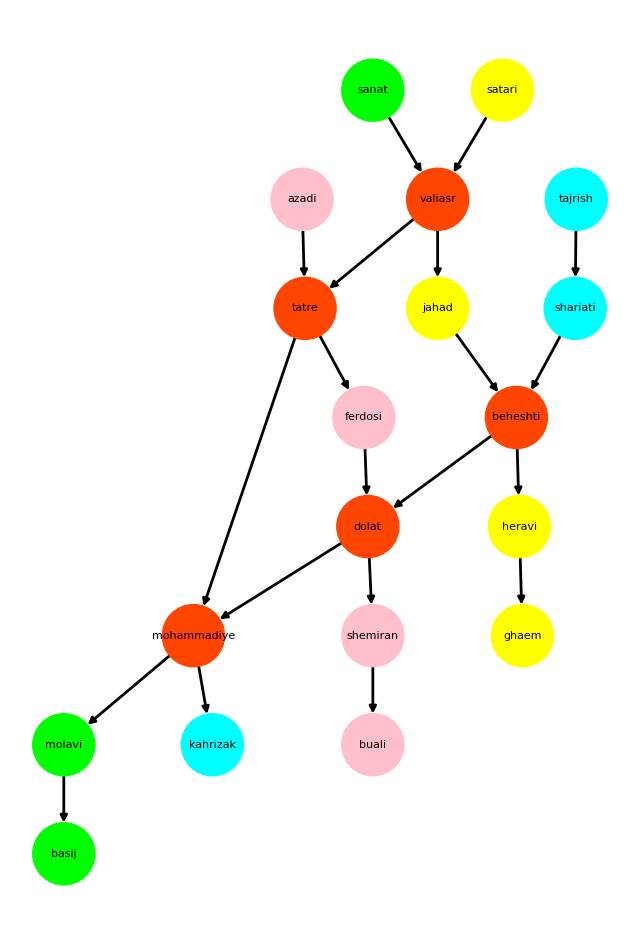

In [2]:
# Create an empty Directed Acyclic Graph
G = nx.DiGraph()

# Define the nodes
# order = [startings, joints, normals, exits]
nodes = ['tajrish', 'sanat', 'satari', 'azadi', 'valiasr', 'tatre', 'beheshti', 'dolat', 'mohammadiye', 'shariati', 'molavi', 'jahad', 'heravi', 'ferdosi', 'shemiran', 'basij', 'kahrizak', 'buali', 'ghaem',]

# Add nodes to the graph
G.add_nodes_from(nodes)

# Define the edges and directions
edges = [("tajrish","shariati"),("shariati","beheshti"),("beheshti","dolat"),("dolat","mohammadiye"),("mohammadiye","kahrizak"),
         ("sanat","valiasr"),("valiasr","tatre"),("tatre","mohammadiye"),("mohammadiye","molavi"),("molavi","basij"),
         ("satari","valiasr"),("valiasr","jahad"),("jahad","beheshti"),("beheshti","heravi"),("heravi","ghaem"),
         ("azadi","tatre"),("tatre","ferdosi"),("ferdosi","dolat"),("dolat","shemiran"),("shemiran","buali"),]

# Add edges to the graph
G.add_edges_from(edges)

# Define the dictionary mapping node names to colors
node_colors = {
    "tajrish": "cyan",
    "shariati": "cyan",
    "beheshti": "orangered",
    "dolat": "orangered",
    "mohammadiye": "orangered",
    "kahrizak": "cyan",
    "sanat": "lime",
    "valiasr": "orangered",
    "tatre": "orangered",
    "molavi": "lime",
    "basij": "lime",
    "satari": "yellow",
    "jahad": "yellow",
    "heravi": "yellow",
    "ghaem": "yellow",
    "azadi": "pink",
    "ferdosi": "pink",
    "shemiran": "pink",
    "buali": "pink",
}

# Draw the graph
fig, ax = plt.subplots(figsize=(8, 12))
pos = graphviz_layout(G, prog="dot", args="-Gnodesep=1 -Granksep=2")
nx.draw_networkx_nodes(G, pos, node_color=[node_colors.get(node, "white") for node in G.nodes()] ,node_size=2000)
nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")
nx.draw_networkx_edges(G, pos, arrows=True, width=2.,node_size=2000)
plt.axis("off")  # Turn off the axis
plt.show()

##### Problems
- At first the passengers will enter stations and wait for the train : therefor people will come and don't exit at the first of the simulation
- As suggested, We will handle joint stations this way : first passengers will leave the station, then half of the remaining ones will go in both directions
- Exit rate = min{entrance-exit, poisson_exit} : given the problem parameters, this ensures correct flow through the stations
- Don't split people in half! : we will use ceil and floor of the half instead of the half itself to prevent splitting people in stations
- Everybody will leave the metro at the last stations : no one will stay there forever!
- There are less people in station than the people who are going to exit! let the exit value = min{people_in_station, exit}

In [10]:
# stations indeces: 
# max-depth = max{dn-dr1, dn-dr2, dn-dr3, dn-dr4}
# max depth of the node is the latest time that station can be opened
stages = np.array([
    [0,1,2,3],
    [4,9,9,9],
    [5,11,11,11],
    [6,13,13,13],
    [7,12,12,12],
    [8,14,18,18],
    [10,16,17,17],
    [15,15,15,15],])

# problem constants
# train number and counting all starts from "zero"
START_TIME = 6*60
END_TIME = 22*60
TRAVL_TIME = 6
CURRENT_DAY = 1
# given the number of the 6 minutes periods, the last metro should arrive 36 minutes before closing time
# because the deepest path has 6 links in it
# Trains will start at 6pm and the last one will end up at 21:56pm  
LAST_TRAIN_TIME = len(stages)-1-1
PERIODS_NUM = ((END_TIME-START_TIME)//TRAVL_TIME)- LAST_TRAIN_TIME


# node order is [startings, joints, normals, exits]
# nodes = ['tajrish', 'sanat', 'satari', 'azadi',
#          'valiasr', 'tatre', 'beheshti', 'dolat', 'mohammadiye',
#          'shariati', 'molavi', 'jahad', 'heravi', 'ferdosi', 'shemiran',
#          'basij', 'kahrizak', 'buali', 'ghaem']
adj_mat = nx.adjacency_matrix(G).toarray()
row_sum = np.sum(adj_mat,axis=-1)
row_sum = np.where(row_sum==0,1,row_sum)
adj_mat = np.einsum("ij,i->ij",adj_mat,1/row_sum)

# entrance of 4 starting stations
# entrance of 11 remaining stations
# nobody will enter the 4 last stations
Λ_Enter = np.floor(np.concatenate((np.random.uniform(low=30, high=40, size=(4)), 
             np.random.uniform(low=10, high=14, size=(11)), np.zeros((4))), axis=-1))

# exit of the 5 joint stations
# exit of 10 remaining stations
# people will leave the last station immediately
Λ_Exit = np.floor(np.concatenate((np.random.uniform(low=15, high=20, size=(5)),
             np.random.uniform(low=8, high=12, size=(10))), axis=-1))

# correction matrix will be summed up with the result of the flow
# after rounding up the result, we will ensure no one get halved!
indeces = np.where(adj_mat==0.5)
correction = np.zeros((19))
correction[indeces[1]] = (0.1)*(-1)**np.arange(indeces[1].shape[0])

# simulation functions
def enter(state,mask): 
    entr = np.random.poisson(Λ_Enter)*mask
    return state+entr, entr
def departure(state,mask):
    exit = np.minimum(np.concatenate((np.random.poisson(Λ_Exit),np.inf*np.ones((4))), axis=-1), state)*mask
    return state-exit, exit
def flow(state): return np.round((state@adj_mat)+correction)
# in the given period, wether passengers must enter specific stations or not
# definitely not if there is not a train
def mask(PERIODS_NUM, CURRENT_STEP): 
    # handle closing time
    delta = 0 if CURRENT_STEP<PERIODS_NUM else CURRENT_STEP-PERIODS_NUM+1
    mask = np.ones((19))
    if delta > 0:
        mask[np.unique(np.concatenate(stages[0:delta], axis=-1))]=0
    # handle starting time
    if CURRENT_STEP < stages.shape[0]-1:
        mask[np.unique(np.concatenate(stages[CURRENT_STEP+1:], axis=-1))]=0
    return mask
    
# do simulation
def simulate(day_n, print_log=False):
    log = []
    log += [['action','time','day']+nodes]
    state = np.zeros((19))
    log += [['init',START_TIME,day_n]+list(state)]
    for CURRENT_STEP in range(PERIODS_NUM+LAST_TRAIN_TIME):
        _mask = mask(PERIODS_NUM, CURRENT_STEP)
        state,entr = enter(state, _mask)
        log += [['enter',START_TIME+(CURRENT_STEP+0)*TRAVL_TIME,day_n]+list(entr.astype(int))]
        # log += [['inside_s',START_TIME+(CURRENT_STEP+0)*TRAVL_TIME,day_n]+list(state.astype(int))]
        state = flow(state)
        log += [['inside_m',START_TIME+(CURRENT_STEP+1)*TRAVL_TIME,day_n]+list(state.astype(int))]
        state,exit = departure(state, _mask)
        log += [['exit',START_TIME+(CURRENT_STEP+1)*TRAVL_TIME,day_n]+list(exit.astype(int))]
        # log += [['inside_e',START_TIME+(CURRENT_STEP+1)*TRAVL_TIME,day_n]+list(state.astype(int))]

    # log whole dataset
    log += [['enter',START_TIME+(CURRENT_STEP+1)*TRAVL_TIME,day_n]+list(np.zeros_like(entr).astype(int))]
    if(print_log): print(tabulate(log, headers="firstrow", tablefmt="fancy_grid"))

    # convert list of lists to dataframe
    return pd.DataFrame(log[2:], columns=log[0])

    
# make dataset
dataset = simulate(day_n=CURRENT_DAY)
for CURRENT_DAY in range(2,31):
    dataset = pd.concat([dataset, simulate(day_n=CURRENT_DAY)], ignore_index=True)

# store dataset
with open("dataset.pkl", "wb") as f:
    pickle.dump(dataset, f)

In [11]:
dataset[:30]

,action,time,day,tajrish,sanat,satari,azadi,valiasr,tatre,beheshti,...,shariati,molavi,jahad,heravi,ferdosi,shemiran,basij,kahrizak,buali,ghaem
0,enter,360,1,32,32,32,36,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,inside_m,366,1,0,0,0,0,64,36,0,...,32,0,0,0,0,0,0,0,0,0
2,exit,366,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,enter,366,1,34,38,32,48,7,0,0,...,13,0,0,0,0,0,0,0,0,0
4,inside_m,372,1,0,0,0,0,70,84,45,...,34,0,35,0,18,0,0,0,0,0
5,exit,372,1,0,0,0,0,9,0,0,...,11,0,0,0,0,0,0,0,0,0
6,enter,372,1,30,27,31,31,10,11,0,...,18,0,9,0,0,0,0,0,0,0
7,inside_m,378,1,0,0,0,0,58,67,85,...,30,9,35,22,47,0,0,9,0,0
8,exit,378,1,0,0,0,0,11,13,0,...,6,0,19,0,0,0,0,0,0,0
9,enter,378,1,40,29,30,34,9,10,8,...,8,0,9,0,16,0,0,0,0,0


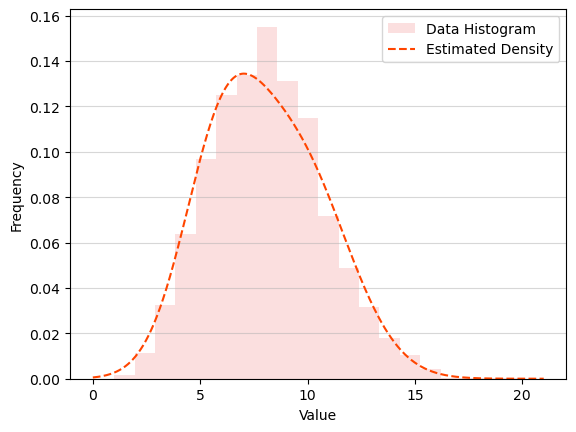

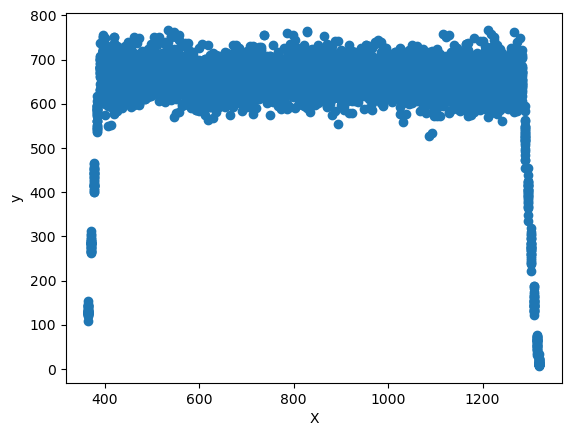

W=[[0.171875, 0.828125]]
M=[[644.40906618 650.10640053]]
V=[[453.25603081 549.08730569]]



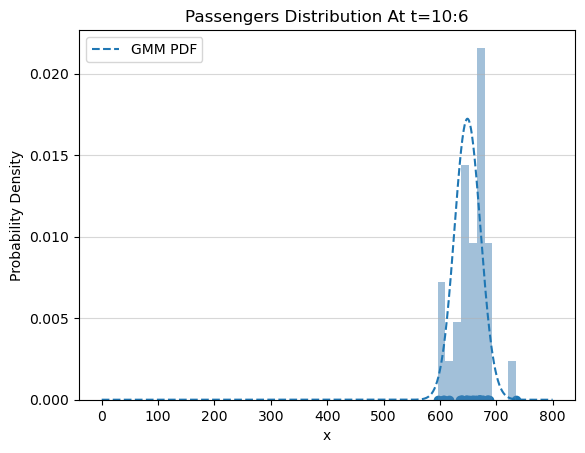

W=[[0.18359375, 0.81640625]]
M=[[641.46850651 653.0469602 ]]
V=[[405.34039338 520.59692667]]



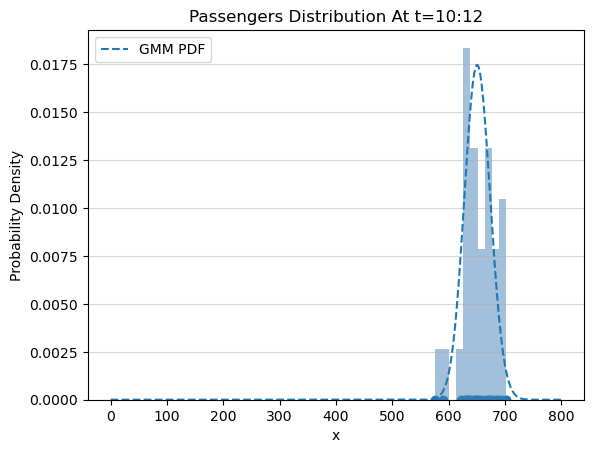

W=[[0.19140625, 0.80859375]]
M=[[640.73336659 654.51724004]]
V=[[398.86530724 510.23678885]]



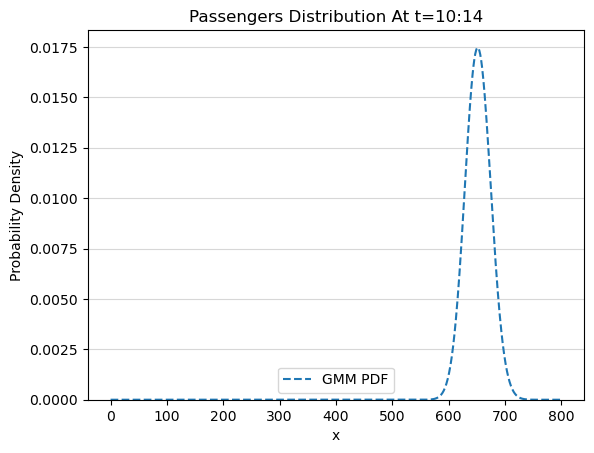

rate=32.29258401022043
32.0


In [12]:
# distribution estimation 
def GMM_Estimate(data,n_components=2):
    gmm = GaussianMixture(n_components)
    gmm.fit(data.reshape(-1,1))
    return gmm

# distributional regression
def DREG_Estimate(data, n_components=2, polynomial=None):
    # we first transform the dataset to (X, bimodal_gmm_params)
    X_unique = np.unique(data[0])
    Y_gmm_params = []
    for X in X_unique:
        gmm = GMM_Estimate(data[1][data[0]==X], n_components=n_components)
        Y_gmm_params += [np.concatenate((gmm.weights_.flatten(),gmm.means_.flatten(),gmm.covariances_.flatten()), axis=-1)]
    # now the problem converted to a simple regression in parameter space
    Y_gmm_params = np.array(Y_gmm_params)
    # we will drive three regressors for each class of variables
    Y_W0 = Y_gmm_params[:,0]
    Y_M  = Y_gmm_params[:,n_components:2*n_components]
    Y_V  = Y_gmm_params[:,2*n_components:]

    # min_max bounds
    Y_M_bounds = (np.min(Y_M),np.max(Y_M))
    Y_V_bounds = (np.min(Y_V),np.max(Y_V))
    
    # normalize values
    Y_M = normalizer(Y_M,Y_M_bounds,inverse=False)
    Y_V = normalizer(Y_V,Y_V_bounds,inverse=False)
    
    MW0 = LinearRegression()
    MM = LinearRegression()
    MV = LinearRegression()

    # normalize domain
    X_min, X_max = np.min(X_unique),np.max(X_unique)
    X = normalizer(X_unique,(X_min, X_max)).reshape(-1, 1)

    # transform domin if needed
    if polynomial!=None:
        X = polynomial.fit_transform(X)    
    
    MW0.fit(X, Y_W0)
    MM.fit(X, Y_M)
    MV.fit(X, Y_V)
    return (MW0,MM,MV), ((0,1),Y_M_bounds,Y_V_bounds), (X_min, X_max)

# normalizer
def normalizer(data, bounds, inverse=False):
    return (bounds[1]-bounds[0])*data+bounds[0] if inverse else (data-bounds[0])/(bounds[1]-bounds[0])

# useful in distribution estimation
def draw_histogram_ProblemAB(data, gmm=None):
    # draw the original histogram
    plt.hist(data, bins=20, density=True, alpha=0.25, color='lightcoral', label='Data Histogram')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    # plt.title('Histogram of Samples')
    plt.grid(axis='y', alpha=0.5)

    # draw the estimated envelope if exists
    if gmm is not None:
        x = np.linspace(data.min() - 1, data.max() + 1, data.shape[0])
        log_density = gmm.score_samples(x.reshape(-1, 1))
        plt.plot(x, np.exp(log_density), label='Estimated Density', linestyle='--', color='orangered')

    # show plot
    plt.legend()
    plt.show()

# useful in regression analysis
def draw_scatter_problemC(data, time=-1):
    X,y = data[0].astype(float), data[1].astype(float)
    if time==-1:
        # coefficients = np.polyfit(X, y, deg=2)
        # X_pred = np.linspace(X.min(), X.max(), X.shape[0])
        # y_pred = np.polyval(coefficients, X_pred)
        # plot actual data points
        plt.scatter(X, y)
        plt.xlabel('X')
        plt.ylabel('y')
        # plot estimated values
        # plt.plot(X_pred, y_pred, color="red")
        plt.show()
    else:
        indeces = np.where(X==time)[0]
        plt.scatter(X[indeces], y[indeces])
        plt.xlabel('X')
        plt.ylabel('y')
        plt.show()

def draw_distribution_problemC(data, poly_t, models, x_bounds, y_bounds, n_components=2, t=600):
    time = poly_t.fit_transform(normalizer(np.array([[t]]),x_bounds))
    # params = [weights, means, covariances]
    W0 = normalizer(models[0].predict(time), bounds=y_bounds[0], inverse=True).reshape(-1)
    W = [W0,1-W0]
    M = normalizer(models[1].predict(time), bounds=y_bounds[1], inverse=True).reshape(-1)
    V = normalizer(models[2].predict(time), bounds=y_bounds[2], inverse=True).reshape(-1)
    
    print(f"W=[{[W0[0],(1-W0)[0]]}]\nM=[{M}]\nV=[{V}]\n")
    x = np.linspace(0, 800, 1000)

    # Compute the PDF at each point
    pdf = np.zeros_like(x)
    for i in range(n_components):
        weight = W[i]
        mean = M[i]
        cov = V[i]
        component_pdf = weight * norm.pdf(x, mean, np.sqrt(np.abs(cov)))
        pdf += component_pdf

    indeces = np.where(data[0]==t)[0]
    plt.plot(x, pdf, label='GMM PDF', linestyle='--')
    plt.scatter(data[1][indeces], np.zeros_like(data[0][indeces]))
    plt.hist(data[1][indeces], bins=10, alpha=0.5, color='steelblue', edgecolor='none', density=True)
    plt.xlabel('x')
    plt.ylabel('Probability Density')
    plt.title(f'Passengers Distribution At t={t//60}:{t%60}')
    plt.grid(axis='y', alpha=0.5)
    plt.legend()
    plt.show()
    
# gather datasets
def stage_population_sample(data_type, station_name='mohammadiye'):
    # de : density estimation
    # re : regression
    if data_type=='de_enter_by_station':
        target = dataset[[station_name,'action']][dataset['action']=='enter'][station_name].values
    elif data_type=='de_exit_by_station':
        target = dataset[[station_name,'action']][dataset['action']=='exit'][station_name].values
    elif data_type=='de_inside_by_station':
        target = dataset[[station_name,'action']][dataset['action']=='inside_m'][station_name].values
    elif data_type=='de_inside_total':
        target = np.sum(dataset[dataset['action']=='inside_m'].values[:,3:], axis=-1)
    elif data_type=='re_inside_by_station':
        target = dataset[[station_name, 'time', 'action']][dataset['action']=='inside_m'][[station_name, 'time']].values
        target = target[target[:,1]!=0]
        return target[:,0], target[:,1]
    elif data_type=='re_inside_total':
        target = dataset[dataset['action']=='inside_m'].values
        y = np.sum(target[:,3:], axis=-1)
        X = target[:,1]
        return X,y
    return target[target!=0]


# # distribution estimation (PART A,B)
data = stage_population_sample(station_name='molavi',data_type='de_exit_by_station')
gmm = GMM_Estimate(data, n_components=2)
draw_histogram_ProblemAB(data, gmm)

# distributional regression analysis (PART C)
data = stage_population_sample('re_inside_total', '')
draw_scatter_problemC(data)
poly_t = PolynomialFeatures(degree=50)
models, y_bounds, x_bounds = DREG_Estimate(data, n_components=2, polynomial=poly_t)
draw_distribution_problemC(data, poly_t, models, x_bounds, y_bounds, n_components=2, t=606)
draw_distribution_problemC(data, poly_t, models, x_bounds, y_bounds, n_components=2, t=612)
draw_distribution_problemC(data, poly_t, models, x_bounds, y_bounds, n_components=2, t=614)

# parameter estimation (PART D)
data = stage_population_sample('de_enter_by_station', 'azadi')
gmm = GMM_Estimate(data, n_components=3)
print(f"rate={np.mean(gmm.means_)}")
print(Λ_Enter[nodes.index('azadi')])

In [33]:
LOAD_MODEL = False
SAVE_MODEL = False
if LOAD_MODEL:
    with open('best_model.pkl', 'wb') as f:
        pickle.dump((models, y_bounds, x_bounds), f)
if SAVE_MODEL:
    with open('best_model.pkl', 'rb') as f:
        model = pickle.load(f)

#### Evaluation

Due to only using the Gaussian Mixture Model as our estimation tool, we can use the distributional distance measure such as total variation distance, wasserstein distance and KL-Divergence. We will use average approximate Cross-Entropy distance and wasserstein distance.

In [26]:
def wasserstein_distance_gmm_his(data, gmm, bins=10):
    histogram = np.histogram(data, bins=bins)
    return wasserstein_distance(histogram[0], gmm.predict_proba(histogram[1].reshape(-1, 1)).reshape(-1)[:-1])

def cross_entropy_distance_gmm_his(data, gmm, bins=10):
    histogram = np.histogram(data, bins=bins)
    return entropy(histogram[0], np.einsum("ij,j->i",gmm.predict_proba(histogram[1].reshape(-1, 1)),gmm.weights_)[:-1])

def gmm_pdf(time, models):
    cov = np.abs(normalizer(models[2].predict(time), bounds=y_bounds[2], inverse=True).reshape(-1))
    mean = normalizer(models[1].predict(time), bounds=y_bounds[1], inverse=True).reshape(-1)
    weight0 = normalizer(models[0].predict(time), bounds=y_bounds[1], inverse=True).reshape(-1)
    return lambda x:norm.pdf(x, mean, np.sqrt(np.abs(cov))), np.array([weight0, 1-weight0]).reshape(-1)

In [356]:
# # PartAB example
# print(f"wasserstein_distance = {wasserstein_distance_gmm_his(data, gmm, bins=100)}")
# print(f"cross_entropy = {cross_entropy_distance_gmm_his(data, gmm, bins=100)}")

# # PartC example
# x_unique = np.unique(data[0])
# x_u_norm = normalizer(x_unique, x_bounds)
# distro = [data[1][np.where(data[0]==x_u)] for x_u in x_unique]
# histos = [np.histogram(data, bins=50) for data in distro]
# midddels = ((histos[0][1][1:]+histos[0][1][:-1])/2)
# normals = [gmm_pdf(poly_t.fit_transform(time), models) for time in normalizer(midddels, (histos[0][1][0],histos[0][1][-1])).reshape(-1,1,1)]
# double_pdfs = [normal[0](midddels.astype(float).reshape(-1,1)) for normal in normals]
# pdfs = [np.einsum("ij,j->i",t[0],t[1][1]) for t in zip(double_pdfs,normals)]
# wasserstein_distance_his_his = np.mean(np.array([wasserstein_distance(t[0],t[1][0]) for t in zip(pdfs,histos)]))
# cross_entropy_distance_his_his = np.mean(np.array([entropy(t[0],t[1][0]) for t in zip(pdfs,histos)]))

# # PartD example
# Λ_Enter_Estimated = [np.mean(GMM_Estimate(stage_population_sample('de_enter_by_station', station), n_components=3).means_) for station in nodes]
# # We know only about the first four station
# print(f"norm-2 loss = {np.linalg.norm(Λ_Enter[:4]-Λ_Enter_Estimated[:4])/4}")
